In [ ]:
!pip install d2l==0.16.1

     |████████████████████████████████| 81kB 7.3MB/s 


# Examples

## Fine-Tuning

[source](https://d2l.ai/chapter_computer-vision/fine-tuning.html)

In earlier chapters, we discussed how to train models on the Fashion-MNIST training dataset, which only has 60,000 images. We also described ImageNet, the most widely used large-scale image dataset in the academic world, with more than 10 million images and objects of over 1000 categories. However, the size of datasets that we often deal with is usually larger than the first, but smaller than the second.

Assume we want to identify different kinds of chairs in images and then push the purchase link to the user. One possible method is to first find a hundred common chairs, take one thousand different images with different angles for each chair, and then train a classification model on the collected image dataset. Although this dataset may be larger than Fashion-MNIST, the number of examples is still less than one tenth of ImageNet. This may result in the overfitting of the complicated model applicable to ImageNet on this dataset. At the same time, because of the limited amount of data, the accuracy of the final trained model may not meet the practical requirements.

In order to deal with the above problems, an obvious solution is to collect more data. However, collecting and labeling data can consume a lot of time and money. For example, in order to collect the ImageNet datasets, researchers have spent millions of dollars of research funding. Although, recently, data collection costs have dropped significantly, the costs still cannot be ignored.

Another solution is to apply transfer learning to migrate the knowledge learned from the source dataset to the target dataset. For example, although the images in ImageNet are mostly unrelated to chairs, models trained on this dataset can extract more general image features that can help identify edges, textures, shapes, and object composition. These similar features may be equally effective for recognizing a chair.

In this section, we introduce a common technique in transfer learning: fine tuning. As shown in :numref:`fig_finetune`, fine tuning consists of the following four steps:

1. Pre-train a neural network model, i.e., the source model, on a source dataset (e.g., the ImageNet dataset).
2. Create a new neural network model, i.e., the target model. This replicates all model designs and their parameters on the source model, except the output layer. We assume that these model parameters contain the knowledge learned from the source dataset and this knowledge will be equally applicable to the target dataset. We also assume that the output layer of the source model is closely related to the labels of the source dataset and is therefore not used in the target model.
3. Add an output layer whose output size is the number of target dataset categories to the target model, and randomly initialize the model parameters of this layer.
4. Train the target model on a target dataset, such as a chair dataset. We will train the output layer from scratch, while the parameters of all remaining layers are fine-tuned based on the parameters of the source model.

![Fine tuning. ](http://d2l.ai/_images/finetune.svg)

### Hot Dog Recognition

Next, we will use a specific example for practice: hot dog recognition. We will fine-tune the ResNet model trained on the ImageNet dataset based on a small dataset. This small dataset contains thousands of images, some of which contain hot dogs. We will use the model obtained by fine tuning to identify whether an image contains a hot dog.

First, import the packages and modules required for the experiment.  Gluon's `model_zoo` package provides a common pre-trained model. If you want to get more pre-trained models for computer vision, you can use the [GluonCV Toolkit](https://gluon-cv.mxnet.io).


In [22]:
%matplotlib inline
from d2l import torch as d2l
from torch import nn
import torch
import torchvision
import os

#### Obtaining the Dataset

The hot dog dataset we use was taken from online images and contains $1,400$ positive images containing hot dogs and the same number of negative images containing other foods. $1,000$ images of various classes are used for training and the rest are used for testing.

We first download the compressed dataset and get two folders `hotdog/train` and `hotdog/test`. Both folders have `hotdog` and `not-hotdog` category subfolders, each of which has corresponding image files.


In [23]:
#@save
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL+'hotdog.zip', 
                         'fba480ffa8aa7e0febbb511d181409f899b9baa5')

data_dir = d2l.download_extract('hotdog')

We create two `ImageFolderDataset` instances to read all the image files in the training dataset and testing dataset, respectively.


In [24]:
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

The first 8 positive examples and the last 8 negative images are shown below. As you can see, the images vary in size and aspect ratio.


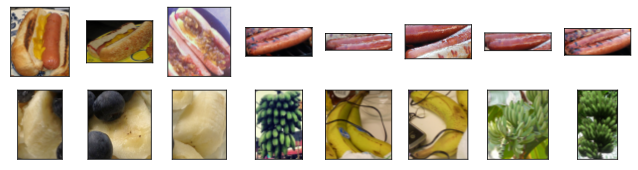

In [25]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i - 1][0] for i in range(8)]
d2l.show_images(hotdogs + not_hotdogs, 2, 8, scale=1.4);

During training, we first crop a random area with random size and random aspect ratio from the image and then scale the area to an input with a height and width of 224 pixels. During testing, we scale the height and width of images to 256 pixels, and then crop the center area with height and width of 224 pixels to use as the input. In addition, we normalize the values of the three RGB (red, green, and blue) color channels. The average of all values of the channel is subtracted from each value and then the result is divided by the standard deviation of all values of the channel to produce the output.


In [26]:
# We specify the mean and variance of the three RGB channels to normalize the
# image channel
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

### Defining and Initializing the Model

We use ResNet-18, which was pre-trained on the ImageNet dataset, as the source model. Here, we specify `pretrained=True` to automatically download and load the pre-trained model parameters. The first time they are used, the model parameters need to be downloaded from the Internet.


In [27]:
pretrained_net = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


The pre-trained source model instance contains two member variables: `features` and `output`. The former contains all layers of the model, except the output layer, and the latter is the output layer of the model. The main purpose of this division is to facilitate the fine tuning of the model parameters of all layers except the output layer. The member variable `output` of source model is given below. As a fully connected layer, it transforms ResNet's final global average pooling layer output into 1000 class output on the ImageNet dataset.


In [28]:
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

We then build a new neural network to use as the target model. It is defined in the same way as the pre-trained source model, but the final number of outputs is equal to the number of categories in the target dataset. In the code below, the model parameters in the member variable `features` of the target model instance `finetune_net` are initialized to model parameters of the corresponding layer of the source model. Because the model parameters in `features` are obtained by pre-training on the ImageNet dataset, it is good enough. Therefore, we generally only need to use small learning rates to "fine-tune" these parameters. In contrast, model parameters in the member variable `output` are randomly initialized and generally require a larger learning rate to learn from scratch. Assume the learning rate in the `Trainer` instance is $\eta$ and use a learning rate of $10\eta$ to update the model parameters in the member variable `output`.


In [29]:
finetune_net = torchvision.models.resnet18(pretrained=True)
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight);
# If `param_group=True`, the model parameters in fc layer will be updated 
# using a learning rate ten times greater, defined in the trainer.

### Fine Tuning the Model

We first define a training function `train_fine_tuning` that uses fine tuning so it can be called multiple times.


In [30]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)    
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

We set the learning rate in the `Trainer` instance to a smaller value, such as 0.01, in order to fine-tune the model parameters obtained in pretraining. Based on the previous settings, we will train the output layer parameters of the target model from scratch using a learning rate ten times greater.


loss 0.204, train acc 0.919, test acc 0.938
326.0 examples/sec on [device(type='cuda', index=0)]


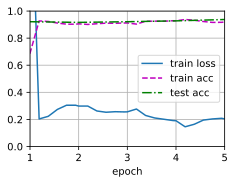

In [31]:
train_fine_tuning(finetune_net, 5e-5)

For comparison, we define an identical model, but initialize all of its model parameters to random values. Since the entire model needs to be trained from scratch, we can use a larger learning rate.


loss 0.372, train acc 0.835, test acc 0.810
1553.0 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1)]


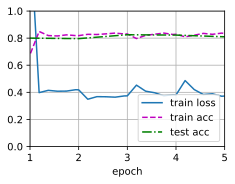

In [ ]:
scratch_net = torchvision.models.resnet18()
scratch_net.fc = nn.Linear(scratch_net.fc.in_features, 2)
train_fine_tuning(scratch_net, 5e-4, param_group=False)

As you can see, the fine-tuned model tends to achieve higher precision in the same epoch because the initial values of the parameters are better.


### Summary


* Transfer learning migrates the knowledge learned from the source dataset to the target dataset. Fine tuning is a common technique for transfer learning.
* The target model replicates all model designs and their parameters on the source model, except the output layer, and fine-tunes these parameters based on the target dataset. In contrast, the output layer of the target model needs to be trained from scratch.
* Generally, fine tuning parameters use a smaller learning rate, while training the output layer from scratch can use a larger learning rate.

In [ ]:
for param in finetune_net.parameters():
    param.requires_grad = False

4. In fact, there is also a "hotdog" class in the `ImageNet` dataset. Its corresponding weight parameter at the output layer can be obtained by using the following code. How can we use this parameter?


In [ ]:
weight = pretrained_net.fc.weight
hotdog_w = torch.split(weight.data, 1, dim=0)[713]
hotdog_w.shape

torch.Size([1, 512])

## Neural style transfer

[source](https://d2l.ai/chapter_computer-vision/neural-style.html)

If you use social sharing apps or happen to be an amateur photographer, you are familiar with filters. Filters can alter the color styles of photos to make the background sharper or people's faces whiter. However, a filter generally can only change one aspect of a photo. To create the ideal photo, you often need to try many different filter combinations. This process is as complex as tuning the hyperparameters of a model.

In this section, we will discuss how we can use convolution neural networks
(CNNs) to automatically apply the style of one image to another image, an
operation known as style transfer :cite:`Gatys.Ecker.Bethge.2016`. Here, we need two input images, one content image and one style image. We use a neural network to alter the content image so that its style mirrors that of the style image. The content image is a landscape photo the author took in Mount Rainier National Part near Seattle. The style image is an oil painting of oak trees in autumn. The output composite image retains the overall shapes of the objects in the content image, but applies the oil painting brushwork of the style image and makes the overall color more vivid.

![Content and style input images and composite image produced by style transfer. ](https://raw.githubusercontent.com/d2l-ai/d2l-pytorch-colab/master/img/style-transfer.svg)

### Technique

The CNN-based style transfer model is shown in :numref:`fig_style_transfer_model`.
First, we initialize the composite image. For example, we can initialize it as the content image. This composite image is the only variable that needs to be updated in the style transfer process, i.e., the model parameter to be updated in style transfer. Then, we select a pre-trained CNN to extract image features. These model parameters do not need to be updated during training. The deep CNN uses multiple neural layers that successively extract image features. We can select the output of certain layers to use as content features or style features. If we use the structure in :numref:`fig_style_transfer_model`, the pre-trained neural network contains three convolutional layers. The second layer outputs the image content features, while the outputs of the first and third layers are used as style features. Next, we use forward propagation (in the direction of the solid lines) to compute the style transfer loss function and backward propagation (in the direction of the dotted lines) to update the model parameter, constantly updating the composite image. The loss functions used in style transfer generally have three parts: 1. Content loss is used to make the composite image approximate the content image as regards content features. 2. Style loss is used to make the composite image approximate the style image in terms of style features. 3. Total variation loss helps reduce the noise in the composite image. Finally, after we finish training the model, we output the style transfer model parameters to obtain the final composite image.

![CNN-based style transfer process. Solid lines show the direction of forward propagation and dotted lines show backward propagation. ](https://raw.githubusercontent.com/d2l-ai/d2l-pytorch-colab/master/img/neural-style.svg)

Next, we will perform an experiment to help us better understand the technical details of style transfer.

### Reading the Content and Style Images

First, we read the content and style images. By printing out the image coordinate axes, we can see that they have different dimensions.


In [ ]:
# Donwloading files locally
!pip install wget
import wget
import os

print('Beginning files download with wget module')

if os.path.exists('rainier.jpg'):
    os.remove('rainier.jpg') 
url = 'https://raw.githubusercontent.com/d2l-ai/d2l-pytorch-colab/master/img/rainier.jpg'
wget.download(url, 'rainier.jpg')

if os.path.exists('autumn-oak.jpg'):
    os.remove('autumn-oak.jpg') 
url = 'https://raw.githubusercontent.com/d2l-ai/d2l-pytorch-colab/master/img/autumn-oak.jpg'
wget.download(url, 'autumn-oak.jpg')

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=8d83aaa369ee704d8b1ee46ce9ff5efe72e535e80433b8f54360ca109fe95b48
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Beginning files download with wget module


'autumn-oak.jpg'

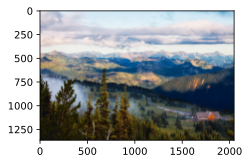

In [ ]:
%matplotlib inline
from d2l import torch as d2l
import torch
import torchvision
from torch import nn



d2l.set_figsize()
content_img = d2l.Image.open('rainier.jpg')
d2l.plt.imshow(content_img);

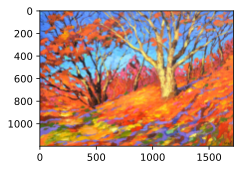

In [ ]:
style_img = d2l.Image.open('autumn-oak.jpg')
d2l.plt.imshow(style_img);

### Preprocessing and Postprocessing

Below, we define the functions for image preprocessing and postprocessing. The `preprocess` function normalizes each of the three RGB channels of the input images and transforms the results to a format that can be input to the CNN. The `postprocess` function restores the pixel values in the output image to their original values before normalization. Because the image printing function requires that each pixel has a floating point value from 0 to 1, we use the `clip` function to replace values smaller than 0 or greater than 1 with 0 or 1, respectively.


In [ ]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

### Extracting Features

We use the VGG-19 model pre-trained on the ImageNet dataset to extract image features[1].


In [ ]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


To extract image content and style features, we can select the outputs of certain layers in the VGG network. In general, the closer an output is to the input layer, the easier it is to extract image detail information. The farther away an output is, the easier it is to extract global information. To prevent the composite image from retaining too many details from the content image, we select a VGG network layer near the output layer to output the image content features. This layer is called the content layer. We also select the outputs of different layers from the VGG network for matching local and global styles. These are called the style layers. As we mentioned in :numref:`sec_vgg`, VGG networks have five convolutional blocks. In this experiment, we select the last convolutional layer of the fourth convolutional block as the content layer and the first layer of each block as style layers. We can obtain the indexes for these layers by printing the `pretrained_net` instance.


In [ ]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

During feature extraction, we only need to use all the VGG layers from the input layer to the content or style layer nearest the output layer. Below, we build a new network, `net`, which only retains the layers in the VGG network we need to use. We then use `net` to extract features.


In [ ]:
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

Given input `X`, if we simply call the forward computation `net(X)`, we can only obtain the output of the last layer. Because we also need the outputs of the intermediate layers, we need to perform layer-by-layer computation and retain the content and style layer outputs.


In [ ]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

Next, we define two functions: The `get_contents` function obtains the content features extracted from the content image, while the `get_styles` function obtains the style features extracted from the style image. Because we do not need to change the parameters of the pre-trained VGG model during training, we can extract the content features from the content image and style features from the style image before the start of training. As the composite image is the model parameter that must be updated during style transfer, we can only call the `extract_features` function during training to extract the content and style features of the composite image.


In [ ]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y

### Defining the Loss Function

Next, we will look at the loss function used for style transfer. The loss function includes the content loss, style loss, and total variation loss.

#### Content Loss

Similar to the loss function used in linear regression, content loss uses a square error function to measure the difference in content features between the composite image and content image. The two inputs of the square error function are both content layer outputs obtained from the `extract_features` function.


In [ ]:
def content_loss(Y_hat, Y):
    # we 'detach' the target content from the tree used
    # to dynamically compute the gradient: this is a stated value,
    # not a variable. Otherwise the loss will throw an error.
    return torch.square(Y_hat - Y.detach()).mean()

#### Style Loss

Style loss, similar to content loss, uses a square error function to measure the difference in style between the composite image and style image. To express the styles output by the style layers, we first use the `extract_features` function to compute the style layer output. Assuming that the output has 1 example, $c$ channels, and a height and width of $h$ and $w$, we can transform the output into the matrix $\mathbf{X}$, which has $c$ rows and $h \cdot w$ columns. You can think of matrix $\mathbf{X}$ as the combination of the $c$ vectors $\mathbf{x}_1, \ldots, \mathbf{x}_c$, which have a length of $hw$. Here, the vector $\mathbf{x}_i$ represents the style feature of channel $i$. In the Gram matrix of these vectors $\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{c \times c}$, element $x_{ij}$ in row $i$ column $j$ is the inner product of vectors $\mathbf{x}_i$ and $\mathbf{x}_j$. It represents the correlation of the style features of channels $i$ and $j$. We use this type of Gram matrix to represent the style output by the style layers. You must note that, when the $h \cdot w$ value is large, this often leads to large values in the Gram matrix. In addition, the height and width of the Gram matrix are both the number of channels $c$. To ensure that the style loss is not affected by the size of these values, we define the `gram` function below to divide the Gram matrix by the number of its elements, i.e., $c \cdot h \cdot w$.


In [ ]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

Naturally, the two Gram matrix inputs of the square error function for style loss are taken from the composite image and style image style layer outputs. Here, we assume that the Gram matrix of the style image, `gram_Y`, has been computed in advance.


In [ ]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

#### Total Variance Loss

Sometimes, the composite images we learn have a lot of high-frequency noise, particularly bright or dark pixels. One common noise reduction method is total variation denoising. We assume that $x_{i, j}$ represents the pixel value at the coordinate $(i, j)$, so the total variance loss is:

$$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right|.$$

We try to make the values of neighboring pixels as similar as possible.


In [ ]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

#### Loss Function

The loss function for style transfer is the weighted sum of the content loss, style loss, and total variance loss. By adjusting these weight hyperparameters, we can balance the retained content, transferred style, and noise reduction in the composite image according to their relative importance.


In [ ]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    # Calculate the content, style, and total variance losses respectively
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    # Add up all the losses
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

### Creating and Initializing the Composite Image

In style transfer, the composite image is the only variable that needs to be updated. Therefore, we can define a simple model, `GeneratedImage`, and treat the composite image as a model parameter. In the model, forward computation only returns the model parameter.


In [ ]:
class GeneratedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(GeneratedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

Next, we define the `get_inits` function. This function creates a composite image model instance and initializes it to the image `X`. The Gram matrix for the various style layers of the style image, `styles_Y_gram`, is computed prior to training.


In [ ]:
def get_inits(X, device, lr, styles_Y):
    gen_img = GeneratedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

### Training

During model training, we constantly extract the content and style features of
the composite image and calculate the loss function. Recall our discussion of
how synchronization functions force the front end to wait for computation
results in :numref:`sec_async`. Because we only call the `asnumpy` synchronization function every 10
epochs, the process may occupy a great deal of memory. Therefore, we call the
`waitall` synchronization function during every epoch.


In [ ]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

Next, we start to train the model. First, we set the height and width of the content and style images to 150 by 225 pixels. We use the content image to initialize the composite image.


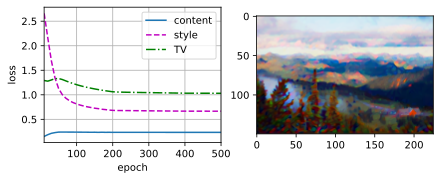

In [ ]:
device, image_shape = d2l.try_gpu(), (150, 225) # PIL Image (h, w)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.01, 500, 200)

As you can see, the composite image retains the scenery and objects of the content image, while introducing the color of the style image. Because the image is relatively small, the details are a bit fuzzy.

To obtain a clearer composite image, we train the model using a larger image size: $900 \times 600$. We increase the height and width of the image used before by a factor of four and initialize a larger composite image.


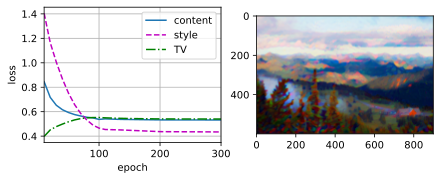

In [ ]:
image_shape = (600, 900) # PIL Image (h, w)
_, content_Y = get_contents(image_shape, device)
_, style_Y = get_styles(image_shape, device)
X = preprocess(postprocess(output), image_shape).to(device)
output = train(X, content_Y, style_Y, device, 0.01, 300, 100)
d2l.plt.imsave('neural-style.jpg', postprocess(output))

As you can see, each epoch takes more time due to the larger image size. As shown in figure, the composite image produced retains more detail due to its larger size. The composite image not only has large blocks of color like the style image, but these blocks even have the subtle texture of brush strokes.

![](neural-style.jpg)

### Summary

* The loss functions used in style transfer generally have three parts: 1. Content loss is used to make the composite image approximate the content image as regards content features. 2. Style loss is used to make the composite image approximate the style image in terms of style features. 3. Total variation loss helps reduce the noise in the composite image.
* We can use a pre-trained CNN to extract image features and minimize the loss function to continuously update the composite image.
* We use a Gram matrix to represent the style output by the style layers.

## Generative Adversarial Networks

Throughout most of this book, we have talked about how to make predictions. In some form or another, we used deep neural networks learned mappings from data examples to labels. This kind of learning is called discriminative learning, as in, we'd like to be able to discriminate between photos cats and photos of dogs. Classifiers and regressors are both examples of discriminative learning. And neural networks trained by backpropagation have upended everything we thought we knew about discriminative learning on large complicated datasets. Classification accuracies on high-res images has gone from useless to human-level (with some caveats) in just 5-6 years. We will spare you another spiel about all the other discriminative tasks where deep neural networks do astoundingly well.

But there is more to machine learning than just solving discriminative tasks. For example, given a large dataset, without any labels, we might want to learn a model that concisely captures the characteristics of this data. Given such a model, we could sample synthetic data examples that resemble the distribution of the training data. For example, given a large corpus of photographs of faces, we might want to be able to generate a new photorealistic image that looks like it might plausibly have come from the same dataset. This kind of learning is called generative modeling.

Until recently, we had no method that could synthesize novel photorealistic images. But the success of deep neural networks for discriminative learning opened up new possibilities. One big trend over the last three years has been the application of discriminative deep nets to overcome challenges in problems that we do not generally think of as supervised learning problems. The recurrent neural network language models are one example of using a discriminative network (trained to predict the next character) that once trained can act as a generative model.

In 2014, a breakthrough paper introduced Generative adversarial networks (GANs) :cite:`Goodfellow.Pouget-Abadie.Mirza.ea.2014`, a clever new way to leverage the power of discriminative models to get good generative models. At their heart, GANs rely on the idea that a data generator is good if we cannot tell fake data apart from real data. In statistics, this is called a two-sample test - a test to answer the question whether datasets $X=\{x_1,\ldots, x_n\}$ and $X'=\{x'_1,\ldots, x'_n\}$ were drawn from the same distribution. The main difference between most statistics papers and GANs is that the latter use this idea in a constructive way. In other words, rather than just training a model to say "hey, these two datasets do not look like they came from the same distribution", they use the [two-sample test](https://en.wikipedia.org/wiki/Two-sample_hypothesis_testing) to provide training signals to a generative model. This allows us to improve the data generator until it generates something that resembles the real data. At the very least, it needs to fool the classifier. Even if our classifier is a state of the art deep neural network.

![Generative Adversarial Networks](http://d2l.ai/_images/gan.svg)

The GAN architecture is illustrated in :numref:`fig_gan`.
As you can see, there are two pieces in GAN architecture - first off, we need a device (say, a deep network but it really could be anything, such as a game rendering engine) that might potentially be able to generate data that looks just like the real thing. If we are dealing with images, this needs to generate images. If we are dealing with speech, it needs to generate audio sequences, and so on. We call this the generator network. The second component is the discriminator network. It attempts to distinguish fake and real data from each other. Both networks are in competition with each other. The generator network attempts to fool the discriminator network. At that point, the discriminator network adapts to the new fake data. This information, in turn is used to improve the generator network, and so on.


The discriminator is a binary classifier to distinguish if the input $x$ is real (from real data) or fake (from the generator). Typically, the discriminator outputs a scalar prediction $o\in\mathbb R$ for input $\mathbf x$, such as using a dense layer with hidden size 1, and then applies sigmoid function to obtain the predicted probability $D(\mathbf x) = 1/(1+e^{-o})$. Assume the label $y$ for the true data is $1$ and $0$ for the fake data. We train the discriminator to minimize the cross-entropy loss, *i.e.*,

$$ \min_D \{ - y \log D(\mathbf x) - (1-y)\log(1-D(\mathbf x)) \},$$

For the generator, it first draws some parameter $\mathbf z\in\mathbb R^d$ from a source of randomness, *e.g.*, a normal distribution $\mathbf z \sim \mathcal{N} (0, 1)$. We often call $\mathbf z$ as the latent variable.
It then applies a function to generate $\mathbf x'=G(\mathbf z)$. The goal of the generator is to fool the discriminator to classify $\mathbf x'=G(\mathbf z)$ as true data, *i.e.*, we want $D( G(\mathbf z)) \approx 1$.
In other words, for a given discriminator $D$, we update the parameters of the generator $G$ to maximize the cross-entropy loss when $y=0$, *i.e.*,

$$ \max_G \{ - (1-y) \log(1-D(G(\mathbf z))) \} = \max_G \{ - \log(1-D(G(\mathbf z))) \}.$$

If the generator does a perfect job, then $D(\mathbf x')\approx 1$ so the above loss near 0, which results the gradients are too small to make a good progress for the discriminator. So commonly we minimize the following loss:

$$ \min_G \{ - y \log(D(G(\mathbf z))) \} = \min_G \{ - \log(D(G(\mathbf z))) \}, $$

which is just feed $\mathbf x'=G(\mathbf z)$ into the discriminator but giving label $y=1$.


To sum up, $D$ and $G$ are playing a "minimax" game with the comprehensive objective function:

$$min_D max_G \{ -E_{x \sim \text{Data}} log D(\mathbf x) - E_{z \sim \text{Noise}} log(1 - D(G(\mathbf z))) \}.$$



Many of the GANs applications are in the context of images. As a demonstration purpose, we are going to content ourselves with fitting a much simpler distribution first. We will illustrate what happens if we use GANs to build the world's most inefficient estimator of parameters for a Gaussian. Let us get started.


In [32]:
%matplotlib inline
from d2l import torch as d2l
import torch
from torch import nn

### Generate some "real" data

Since this is going to be the world's lamest example, we simply generate data drawn from a Gaussian.


In [33]:
X = torch.normal(0.0, 1, (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b

Let us see what we got. This should be a Gaussian shifted in some rather arbitrary way with mean $b$ and covariance matrix $A^TA$.


The covariance matrix is
tensor([[1.0100, 1.9500],
        [1.9500, 4.2500]])


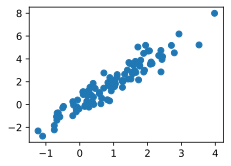

In [34]:
d2l.set_figsize()
d2l.plt.scatter(data[:100, (0)].detach().numpy(), data[:100,
                                                       (1)].detach().numpy())
print(f'The covariance matrix is\n{torch.matmul(A.T, A)}')

In [35]:
batch_size = 8
data_iter = d2l.load_array((data,), batch_size)

### Generator

Our generator network will be the simplest network possible - a single layer linear model. This is since we will be driving that linear network with a Gaussian data generator. Hence, it literally only needs to learn the parameters to fake things perfectly.


In [38]:
net_G = nn.Sequential(nn.Linear(2, 2))

### Discriminator

For the discriminator we will be a bit more discriminating: we will use an MLP with 3 layers to make things a bit more interesting.


In [37]:
net_D = nn.Sequential(
    nn.Linear(2, 5), nn.Tanh(),
    nn.Linear(5, 3), nn.Tanh(),
    nn.Linear(3, 1))

### Training

First we define a function to update the discriminator.


In [39]:
#@save
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    """Update discriminator."""
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)
    # Do not need to compute gradient for `net_G`, detach it from
    # computing gradients.
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) + 
              loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D

The generator is updated similarly. Here we reuse the cross-entropy loss but change the label of the fake data from $0$ to $1$.


In [40]:
#@save
def update_G(Z, net_D, net_G, loss, trainer_G):
    """Update generator."""
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    # We could reuse `fake_X` from `update_D` to save computation
    fake_X = net_G(Z)
    # Recomputing `fake_Y` is needed since `net_D` is changed
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss_G.backward()
    trainer_G.step()
    return loss_G

Both the discriminator and the generator performs a binary logistic regression with the cross-entropy loss. We use Adam to smooth the training process. In each iteration, we first update the discriminator and then the generator. We visualize both losses and generated examples.


In [41]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(num_epochs):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for (X,) in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim))
            metric.add(update_D(X, Z, net_D, net_G, loss, trainer_D),
                       update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Visualize generated examples
        Z = torch.normal(0, 1, size=(100, latent_dim))
        fake_X = net_G(Z).detach().numpy()
        animator.axes[1].cla()
        animator.axes[1].scatter(data[:, 0], data[:, 1])
        animator.axes[1].scatter(fake_X[:, 0], fake_X[:, 1])
        animator.axes[1].legend(['real', 'generated'])
        # Show the losses
        loss_D, loss_G = metric[0]/metric[2], metric[1]/metric[2]
        animator.add(epoch + 1, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec')

Now we specify the hyperparameters to fit the Gaussian distribution.


loss_D 0.693, loss_G 0.695, 1953.1 examples/sec


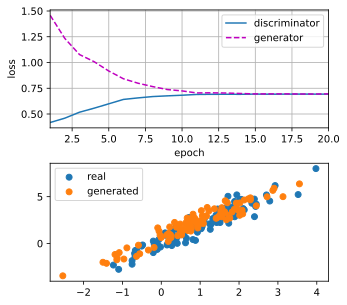

In [44]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim,
      data[:100].detach().numpy())

### Summary

* Generative adversarial networks (GANs) composes of two deep networks, the generator and the discriminator.
* The generator generates the image as much closer to the true image as possible to fool the discriminator, via maximizing the cross-entropy loss, *i.e.*, $\max \log(D(\mathbf{x'}))$.
* The discriminator tries to distinguish the generated images from the true images, via minimizing the cross-entropy loss, *i.e.*, $\min - y \log D(\mathbf{x}) - (1-y)\log(1-D(\mathbf{x}))$.


## Deep Convolutional GAN

In previous section, we introduced the basic ideas behind how GANs work. We showed that they can draw samples from some simple, easy-to-sample distribution, like a uniform or normal distribution, and transform them into samples that appear to match the distribution of some dataset. And while our example of matching a 2D Gaussian distribution got the point across, it is not especially exciting.

In this section, we will demonstrate how you can use GANs to generate photorealistic images. We will be basing our models on the deep convolutional GANs (DCGAN) introduced in :cite:`Radford.Metz.Chintala.2015`. We will borrow the convolutional architecture that have proven so successful for discriminative computer vision problems and show how via GANs, they can be leveraged to generate photorealistic images.


In [45]:
from d2l import torch as d2l
import torch
import torchvision
from torch import nn
import warnings

### The Pokemon Dataset

The dataset we will use is a collection of Pokemon sprites obtained from [pokemondb](https://pokemondb.net/sprites). First download, extract and load this dataset.


In [46]:
#@save
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)

We resize each image into $64\times 64$. The `ToTensor` transformation will project the pixel value into $[0, 1]$, while our generator will use the tanh function to obtain outputs in $[-1, 1]$. Therefore we normalize the data with $0.5$ mean and $0.5$ standard deviation to match the value range.


In [47]:
batch_size = 256
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])
pokemon.transform = transformer
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size,
    shuffle=True, num_workers=d2l.get_dataloader_workers())

Let us visualize the first 20 images.


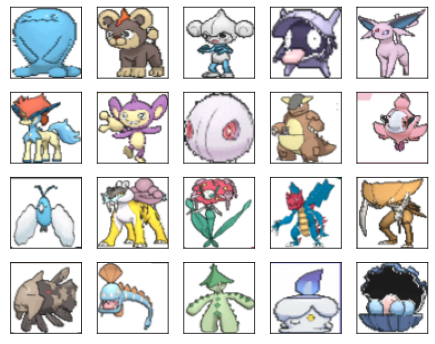

In [48]:
warnings.filterwarnings('ignore')
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[0:20,:,:,:].permute(0, 2, 3, 1)/2+0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break

### The Generator

The generator needs to map the noise variable $\mathbf z\in\mathbb R^d$, a length-$d$ vector, to a RGB image with width and height to be $64\times 64$ . In :numref:`sec_fcn` we introduced the fully convolutional network that uses transposed convolution layer (refer to :numref:`sec_transposed_conv`) to enlarge input size. The basic block of the generator contains a transposed convolution layer followed by the batch normalization and ReLU activation.


In [49]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In default, the transposed convolution layer uses a $k_h = k_w = 4$ kernel, a $s_h = s_w = 2$ strides, and a $p_h = p_w = 1$ padding. With a input shape of $n_h^{'} \times n_w^{'} = 16 \times 16$, the generator block will double input's width and height.

$$
\begin{aligned}
n_h^{'} \times n_w^{'} &= [(n_h k_h - (n_h-1)(k_h-s_h)- 2p_h] \times [(n_w k_w - (n_w-1)(k_w-s_w)- 2p_w]\\
  &= [(k_h + s_h (n_h-1)- 2p_h] \times [(k_w + s_w (n_w-1)- 2p_w]\\
  &= [(4 + 2 \times (16-1)- 2 \times 1] \times [(4 + 2 \times (16-1)- 2 \times 1]\\
  &= 32 \times 32 .\\
\end{aligned}
$$


In [50]:
x = torch.zeros((2, 3, 16, 16))
g_blk = G_block(20)
g_blk(x).shape

torch.Size([2, 20, 32, 32])

If changing the transposed convolution layer to a $4\times 4$ kernel, $1\times 1$ strides and zero padding. With a input size of $1 \times 1$, the output will have its width and height increased by 3 respectively.


In [51]:
x = torch.zeros((2, 3, 1, 1))
g_blk = G_block(20, strides=1, padding=0)
g_blk(x).shape

torch.Size([2, 20, 4, 4])

The generator consists of four basic blocks that increase input's both width and height from 1 to 32. At the same time, it first projects the latent variable into $64\times 8$ channels, and then halve the channels each time. At last, a transposed convolution layer is used to generate the output. It further doubles the width and height to match the desired $64\times 64$ shape, and reduces the channel size to $3$. The tanh activation function is applied to project output values into the $(-1, 1)$ range.


In [52]:
n_G = 64
net_G = nn.Sequential(
    G_block(in_channels=100, out_channels=n_G*8,
            strides=1, padding=0),                  # Output: (64 * 8, 4, 4)
    G_block(in_channels=n_G*8, out_channels=n_G*4), # Output: (64 * 4, 8, 8)
    G_block(in_channels=n_G*4, out_channels=n_G*2), # Output: (64 * 2, 16, 16)
    G_block(in_channels=n_G*2, out_channels=n_G),   # Output: (64, 32, 32)
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3, 
                       kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())  # Output: (3, 64, 64)

Generate a 100 dimensional latent variable to verify the generator's output shape.


In [53]:
x = torch.zeros((1, 100, 1, 1))
net_G(x).shape

torch.Size([1, 3, 64, 64])

### Discriminator

The discriminator is a normal convolutional network network except that it uses a leaky ReLU as its activation function. Given $\alpha \in[0, 1]$, its definition is

$$\textrm{leaky ReLU}(x) = \begin{cases}x & \text{if}\ x > 0\\ \alpha x &\text{otherwise}\end{cases}.$$

As it can be seen, it is normal ReLU if $\alpha=0$, and an identity function if $\alpha=1$. For $\alpha \in (0, 1)$, leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the "dying ReLU" problem that a neuron might always output a negative value and therefore cannot make any progress since the gradient of ReLU is 0.


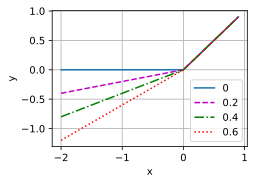

In [54]:
alphas = [0, .2, .4, .6, .8, 1]
x = torch.arange(-2, 1, 0.1)
Y = [nn.LeakyReLU(alpha)(x).detach().numpy() for alpha in alphas]
d2l.plot(x.detach().numpy(), Y, 'x', 'y', alphas)

The basic block of the discriminator is a convolution layer followed by a batch normalization layer and a leaky ReLU activation. The hyperparameters of the convolution layer are similar to the transpose convolution layer in the generator block.


In [55]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

A basic block with default settings will halve the width and height of the inputs, as we demonstrated in :numref:`sec_padding`. For example, given a input shape $n_h = n_w = 16$, with a kernel shape $k_h = k_w = 4$, a stride shape $s_h = s_w = 2$, and a padding shape $p_h = p_w = 1$, the output shape will be:

$$
\begin{aligned}
n_h^{'} \times n_w^{'} &= \lfloor(n_h-k_h+2p_h+s_h)/s_h\rfloor \times \lfloor(n_w-k_w+2p_w+s_w)/s_w\rfloor\\
  &= \lfloor(16-4+2\times 1+2)/2\rfloor \times \lfloor(16-4+2\times 1+2)/2\rfloor\\
  &= 8 \times 8 .\\
\end{aligned}
$$


In [56]:
x = torch.zeros((2, 3, 16, 16))
d_blk = D_block(20)
d_blk(x).shape

torch.Size([2, 20, 8, 8])

The discriminator is a mirror of the generator.


In [57]:
n_D = 64
net_D = nn.Sequential(
    D_block(n_D),  # Output: (64, 32, 32)
    D_block(in_channels=n_D, out_channels=n_D*2),  # Output: (64 * 2, 16, 16)
    D_block(in_channels=n_D*2, out_channels=n_D*4),  # Output: (64 * 4, 8, 8)
    D_block(in_channels=n_D*4, out_channels=n_D*8),  # Output: (64 * 8, 4, 4)
    nn.Conv2d(in_channels=n_D*8, out_channels=1,
              kernel_size=4, bias=False))  # Output: (1, 1, 1)

It uses a convolution layer with output channel $1$ as the last layer to obtain a single prediction value.


In [58]:
x = torch.zeros((1, 3, 64, 64))
net_D(x).shape

torch.Size([1, 1, 1, 1])

### Training

Compared to the basic GAN in :numref:`sec_basic_gan`, we use the same learning rate for both generator and discriminator since they are similar to each other. In addition, we change $\beta_1$ in Adam (:numref:`sec_adam`) from $0.9$ to $0.5$. It decreases the smoothness of the momentum, the exponentially weighted moving average of past gradients, to take care of the rapid changing gradients because the generator and the discriminator fight with each other. Besides, the random generated noise `Z`, is a 4-D tensor and we are using GPU to accelerate the computation.


In [59]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D, net_G = net_D.to(device), net_G.to(device)
    trainer_hp = {'lr': lr, 'betas': [0.5,0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
        imgs = torch.cat(
            [torch.cat([
                fake_x[i * 7 + j].cpu().detach() for j in range(7)], dim=1)
             for i in range(len(fake_x)//7)], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

We train the model with a small number of epochs just for demonstration.
For better performance,
the variable `num_epochs` can be set to a larger number.


loss_D 0.100, loss_G 8.246, 533.4 examples/sec on cuda:0


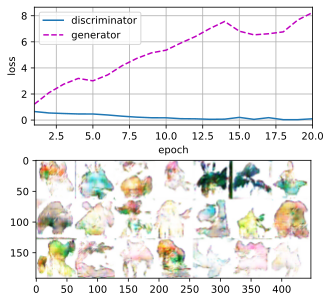

In [60]:
latent_dim, lr, num_epochs = 100, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)

### Summary

* DCGAN architecture has four convolutional layers for the Discriminator and four "fractionally-strided" convolutional layers for the Generator.
* The Discriminator is a 4-layer strided convolutions with batch normalization (except its input layer) and leaky ReLU activations.
* Leaky ReLU is a nonlinear function that give a non-zero output for a negative input. It aims to fix the “dying ReLU” problem and helps the gradients flow easier through the architecture.

## Keras

We want to make machine learning and data analysis like this in the future:

```python
import autokeras as ak

clf = ak.ImageClassifier()
clf.fit(x_train, y_train)
results = clf.predict(x_test)
```

😀))000)))

### MNIST example

![](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

In [78]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
import keras.datasets

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [79]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

In [80]:
X_train = X_train / 255 
X_test = X_test / 255

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

In [81]:
input_size = X_train[0].shape
input_size

(28, 28)

In [82]:
X_train.shape

(60000, 28, 28)

In [83]:
model = Sequential()

In [84]:
model.add(Flatten(input_shape=input_size))
model.add(Dense(units=128, input_shape=input_size))
model.add(Activation('relu'))
model.add(Dense(units=10))
model.add(Activation('softmax'))

In [85]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [86]:
model.fit(X_train, y_train, epochs=5, batch_size=40)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 50us/sample - loss: 0.2750 - acc: 0.9219
Epoch 2/5
60000/60000 [==============================] - 3s 49us/sample - loss: 0.1209 - acc: 0.9639
Epoch 3/5
60000/60000 [==============================] - 3s 47us/sample - loss: 0.0835 - acc: 0.9748
Epoch 4/5
60000/60000 [==============================] - 3s 51us/sample - loss: 0.0632 - acc: 0.9807
Epoch 5/5
60000/60000 [==============================] - 3s 53us/sample - loss: 0.0484 - acc: 0.9845


In [93]:
from keras import backend as K
K.backend()

'tensorflow'

In [94]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
activation (Activation)      (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [95]:
model.evaluate(X_test, y_test)

[0.07062886288294103, 0.9763]

#### Add convolutions

![](https://raw.githubusercontent.com/MerkulovDaniil/TensorFlow_and_Keras_crash_course/master/rus/2_Deep%20Learning%20and%20Keras/convol.gif)

![](https://raw.githubusercontent.com/MerkulovDaniil/TensorFlow_and_Keras_crash_course/master/rus/2_Deep%20Learning%20and%20Keras/features.png)

![](https://github.com/MerkulovDaniil/TensorFlow_and_Keras_crash_course/blob/master/rus/2_Deep%20Learning%20and%20Keras/dropout.gif?raw=true)

In [97]:
X_train, X_test = X_train.reshape((60000, 28, 28, 1)), X_test.reshape((10000, 28, 28, 1))
input_size = X_train[0].shape
print(input_size)

(28, 28, 1)


In [98]:
from keras.layers import Conv2D

In [99]:
conv_model = Sequential()

In [100]:
conv_model.add(Conv2D(24, (3, 3), input_shape=input_size))
conv_model.add(Activation('relu'))
conv_model.add(Flatten())
conv_model.add(Dense(64, activation='relu'))
conv_model.add(Dense(10, activation='softmax'))

In [101]:
conv_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [102]:
conv_model.fit(X_train, y_train, epochs=5, batch_size=32)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 5s 84us/sample - loss: 0.1536 - acc: 0.9540
Epoch 2/5
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0510 - acc: 0.9844
Epoch 3/5
60000/60000 [==============================] - 5s 86us/sample - loss: 0.0296 - acc: 0.9908
Epoch 4/5
60000/60000 [==============================] - 5s 80us/sample - loss: 0.0188 - acc: 0.9940
Epoch 5/5
60000/60000 [==============================] - 5s 81us/sample - loss: 0.0125 - acc: 0.9962


In [103]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 24)        240       
_________________________________________________________________
activation_2 (Activation)    (None, 26, 26, 24)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16224)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                1038400   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                650       
Total params: 1,039,290
Trainable params: 1,039,290
Non-trainable params: 0
_________________________________________________________________


In [104]:
conv_model.evaluate(X_test, y_test)

[0.06279953023338385, 0.9827]

In [106]:
from keras.layers import MaxPooling2D, Dropout

# Все так же, создаем модель
cnn = Sequential()

# Начинаем со сверточного слоя, указывая тип активации на выходе из него и способ заполнения краев (padding)
cnn.add(Conv2D(64, (3, 3), input_shape=input_size, activation='selu', padding='same'))

# Здесь мы используем метод MaxPooling, который уменьшает размер обрабатываемого изображения, 
# выбирая из 4 пикселей 1 с максимальным значением, чтобы это быстрее считалось. (2,2) -> 1
cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Слой dropout, который на каждом шаге "выключает" 25% случайно выбранных нейронов
cnn.add(Dropout(0.25))

# Еще сверточный слой
cnn.add(Conv2D(32, (3, 3), input_shape=input_size, activation='selu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

cnn.add(Dropout(0.5))

# Последний слой необходим для классификации, но перед ним необходимо векторизовать данные
cnn.add(Flatten())
cnn.add(Dense(10, activation='softmax'))


cnn.compile(loss='categorical_crossentropy',
                  optimizer = 'nadam',
                  metrics = ['accuracy'])

history_cnn = cnn.fit(X_train, y_train,
      batch_size=128,
      epochs=5,
      validation_data=(X_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 59us/sample - loss: 0.3664 - acc: 0.8874 - val_loss: 0.0966 - val_acc: 0.9702
Epoch 2/5
60000/60000 [==============================] - 3s 54us/sample - loss: 0.1309 - acc: 0.9602 - val_loss: 0.0611 - val_acc: 0.9803
Epoch 3/5
60000/60000 [==============================] - 3s 54us/sample - loss: 0.1028 - acc: 0.9684 - val_loss: 0.0498 - val_acc: 0.9839
Epoch 4/5
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0893 - acc: 0.9719 - val_loss: 0.0465 - val_acc: 0.9852
Epoch 5/5
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0824 - acc: 0.9740 - val_loss: 0.0411 - val_acc: 0.9870


In [107]:
history_cnn.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

Text(0.5, 0, 'epoch')

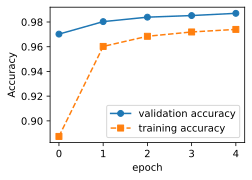

In [108]:
plt.plot(range(len(history_cnn.history['val_acc'])), history_cnn.history['val_acc'], '-o', label='validation accuracy')
plt.plot(range(len(history_cnn.history['acc'])),     history_cnn.history['acc'], '--s', label='training accuracy')
plt.legend();
plt.ylabel('Accuracy')
plt.xlabel('epoch')

### Pushkin


![](https://www.meme-arsenal.com/memes/fef016cb71d40e3c893274c41afb3cbe.jpg)


In [109]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io

In [110]:
path = get_file(
    'pushkin.txt',
    origin='https://raw.githubusercontent.com/MerkulovDaniil/TensorFlow_and_Keras_crash_course/master/pushkin.txt')
#     origin="https://s3.amazonaws.com/text-datasets/nietzsche.txt")             # Тексты Ницше
with io.open(path, encoding='utf-8') as f:
    text = f.read().lower()
print('Размер корпуса:', len(text))

942080/941229 [==============================] - 0s 0us/step
Размер корпуса: 525864


In [111]:
chars = sorted(list(set(text)))
print('Всего символов:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

Всего символов: 85


In [112]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Количество фраз:', len(sentences))

Количество фраз: 175275


In [113]:
print('Векторизация...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Векторизация...


In [114]:
# build the model: a single LSTM
print('Строим модель...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Строим модель...


In [115]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Вот, что я могу сказать по этому поводу после эпохи № %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.1, 0.2, 0.3]:
        print('----- Вариативность:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Входная последовательность: "' + sentence + '"')
        sys.stdout.write('🤖: ' + generated)

        for i in range(300):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
        
    print()
    print('----- Не злитесь, я только учусь 🐱')

In [ ]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y,
          batch_size=128,
          epochs=50,
          callbacks=[print_callback])

### Autokeras

[source](https://autokeras.com/tutorial/overview/)

In [ ]:
!pip install autokeras

#### A Simple Example
The first step is to prepare your data. Here we use the MNIST dataset as an example


In [63]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import autokeras as ak

(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)  # (60000, 28, 28)
print(y_train.shape)  # (60000,)
print(y_train[:3])  # array([7, 2, 1], dtype=uint8)


(60000, 28, 28)
(60000,)
[5 0 4]


In [69]:
!pip install keras --upgrade

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


The second step is to run the ImageClassifier.
It is recommended have more trials for more complicated datasets.
This is just a quick demo of MNIST, so we set max_trials to 1.
For the same reason, we set epochs to 10.
You can also leave the epochs unspecified for an adaptive number of epochs.


In [64]:
# Initialize the image classifier.
clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=1)
# Feed the image classifier with training data.
clf.fit(x_train, y_train, epochs=10)


# Predict with the best model.
predicted_y = clf.predict(x_test)
print(predicted_y)


# Evaluate the best model with testing data.
print(clf.evaluate(x_test, y_test))


Trial 1 Complete [00h 01m 19s]
val_loss: 0.04011617973446846

Best val_loss So Far: 0.04011617973446846
Total elapsed time: 00h 01m 19s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3012 - accuracy: 0.9071
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0781 - accuracy: 0.9759
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0648 - accuracy: 0.9801
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0534 - accuracy: 0.9835
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0473 - accuracy: 0.9843
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0419 - accuracy: 0.9865
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0386 - accuracy: 0.9878
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0356 - accuracy: 0.9885
Epoch 9/10

#### Validation Data
By default, AutoKeras use the last 20% of training data as validation data. As shown in
the example below, you can use validation_split to specify the percentage.


In [65]:
clf.fit(
    x_train,
    y_train,
    # Split the training data and use the last 15% as validation data.
    validation_split=0.15,
    epochs=10,
)


In [66]:
split = 50000
x_val = x_train[split:]
y_val = y_train[split:]
x_train = x_train[:split]
y_train = y_train[:split]
clf.fit(
    x_train,
    y_train,
    # Use your own validation set.
    validation_data=(x_val, y_val),
    epochs=10,
)


#### Customized Search Space
For advanced users, you may customize your search space by using AutoModel instead of
ImageClassifier. You can configure the ImageBlock for some high-level configurations,
e.g., block_type for the type of neural network to search, normalize for whether to do
data normalization, augment for whether to do data augmentation. You can also do not
specify these arguments, which would leave the different choices to be tuned
automatically. See the following example for detail.


In [ ]:
input_node = ak.ImageInput()
output_node = ak.ImageBlock(
    # Only search ResNet architectures.
    block_type="resnet",
    # Normalize the dataset.
    normalize=True,
    # Do not do data augmentation.
    augment=False,
)(input_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
    max_trials=1)
clf.fit(x_train, y_train, epochs=10)


The usage of AutoModel is similar to the functional API of Keras. Basically, you are
building a graph, whose edges are blocks and the nodes are intermediate outputs of
blocks. To add an edge from input_node to output_node with output_node =
ak.[some_block]([block_args])(input_node).

You can even also use more fine grained blocks to customize the search space even
further. See the following example.


In [74]:
input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node = ak.ImageAugmentation(horizontal_flip=False)(output_node)
output_node = ak.ResNetBlock(version="v2")(output_node)
output_node = ak.ClassificationHead()(output_node)
clf = ak.AutoModel(
    inputs=input_node,
    outputs=output_node,
    overwrite=True,
    max_trials=1)
clf.fit(x_train, y_train, epochs=2)


Trial 1 Complete [00h 02m 59s]
val_loss: 0.1333337426185608

Best val_loss So Far: 0.1333337426185608
Total elapsed time: 00h 02m 59s
INFO:tensorflow:Oracle triggered exit
Epoch 1/2
1563/1563 [==============================] - 103s 60ms/step - loss: 0.5831 - accuracy: 0.8263
Epoch 2/2
1563/1563 [==============================] - 94s 60ms/step - loss: 0.2448 - accuracy: 0.9385
INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


#### Data Format
The AutoKeras ImageClassifier is quite flexible for the data format.

For the image, it accepts data formats both with and without the channel dimension. The
images in the MNIST dataset do not have the channel dimension. Each image is a matrix
with shape (28, 28). AutoKeras also accepts images of three dimensions with the channel
dimension at last, e.g., (32, 32, 3), (28, 28, 1).

For the classification labels, AutoKeras accepts both plain labels, i.e. strings or
integers, and one-hot encoded encoded labels, i.e. vectors of 0s and 1s.

So if you prepare your data in the following way, the ImageClassifier should still work.


In [75]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape the images to have the channel dimension.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

# One-hot encode the labels.
eye = np.eye(10)
y_train = eye[y_train]
y_test = eye[y_test]

print(x_train.shape)  # (60000, 28, 28, 1)
print(y_train.shape)  # (60000, 10)
print(y_train[:3])
# array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
#        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
#        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])


(60000, 28, 28, 1)
(60000, 10)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


We also support using tf.data.Dataset format for the training data.


In [76]:
train_set = tf.data.Dataset.from_tensor_slices(((x_train,), (y_train,)))
test_set = tf.data.Dataset.from_tensor_slices(((x_test,), (y_test,)))

clf = ak.ImageClassifier(
    overwrite=True,
    max_trials=1)
# Feed the tensorflow Dataset to the classifier.
clf.fit(train_set, epochs=10)
# Predict with the best model.
predicted_y = clf.predict(test_set)
# Evaluate the best model with testing data.
print(clf.evaluate(test_set))


Trial 1 Complete [00h 01m 25s]
val_loss: 0.03724956139922142

Best val_loss So Far: 0.03724956139922142
Total elapsed time: 00h 01m 25s
INFO:tensorflow:Oracle triggered exit
Epoch 1/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3004 - accuracy: 0.9089
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0816 - accuracy: 0.9754
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0622 - accuracy: 0.9807
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0543 - accuracy: 0.9825
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0475 - accuracy: 0.9855
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0412 - accuracy: 0.9875
Epoch 7/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0373 - accuracy: 0.9883
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0363 - accuracy: 0.9882
Epoch 9/10

# Exercises

## Fine- Tuning

1. Keep increasing the learning rate of `finetune_net`. How does the precision of the model change?
2. Further tune the hyperparameters of `finetune_net` and `scratch_net` in the comparative experiment. Do they still have different precisions?
3. Set the parameters in `finetune_net.features` to the parameters of the source model and do not update them during training. What will happen? You can use the following code.

## Neural style transfer

1. How does the output change when you select different content and style layers?
1. Adjust the weight hyperparameters in the loss function. Does the output retain more content or have less noise?
1. Use different content and style images. Can you create more interesting composite images?
1. Can we apply style transfer for text? Hint: you may refer to the survey paper by Hu et al. :cite:`Hu.Lee.Aggarwal.2020`.


## GANs

1. Does an equilibrium exist where the generator wins, *i.e.* the discriminator ends up unable to distinguish the two distributions on finite samples?
1. What will happen if we use standard ReLU activation rather than leaky ReLU?
1. Apply DCGAN on Fashion-MNIST and see which category works well and which does not.
